# Mobile Phone Price Prediction using Machine Learning

## Step 1: Importing Required Libraries and Models


In [190]:
# ============================
# Import Required Libraries
# ============================

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Tabular Results
from tabulate import tabulate

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Step 2: Data Collection 

In [191]:
data = pd.read_csv('Mobiles-Dataset-2025.csv', encoding='latin1')

In [192]:
# data = data[['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)']]
data.shape

(930, 15)

## Step 3: Data Preprocessing

In [193]:
# Check for null value
data.isnull().sum()

Company Name                 0
Model Name                   0
Mobile Weight                0
RAM                          0
Front Camera                 0
Back Camera                  0
Processor                    0
Battery Capacity             0
Screen Size                  0
Launched Price (Pakistan)    0
Launched Price (India)       0
Launched Price (China)       0
Launched Price (USA)         0
Launched Price (Dubai)       0
Launched Year                0
dtype: int64

In [194]:
from sklearn.preprocessing import LabelEncoder

# --- Cleaning process ---
cols_to_drop = [
    'Launched Price (Dubai)',
    'Launched Price (China)',
    'Launched Price (India)',
    'Launched Price (Pakistan)'
]
data = data.drop(columns=cols_to_drop)

print("Columns:", data.columns.tolist())


Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']


In [195]:
# Helper function to clean numeric columns
def clean_numeric(series, remove_str="", round_to_int=False):
    cleaned = (
        series.astype(str)
        .str.replace(remove_str, "", regex=False)
        .str.replace("Not available", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]   
    )
    cleaned = pd.to_numeric(cleaned, errors="coerce")
    
    if round_to_int:
        cleaned = cleaned.round().astype("Int64")  
    return cleaned

def extract_rom(model_name):
    model_name = str(model_name).upper()
    match_tb = re.search(r'(\d+)TB', model_name)
    if match_tb:
        return float(match_tb.group(1))
    match_gb = re.search(r'(\d+)GB', model_name)
    if match_gb:
        return float(match_gb.group(1)) / 1024
    return np.nan

print("Columns:", data.columns.tolist())

# Mobile Weight
if "Mobile Weight" in data.columns:
    data["Mobile Weight"] = clean_numeric(data["Mobile Weight"], remove_str="g")

# RAM
if "RAM" in data.columns:
    data["RAM"] = clean_numeric(data["RAM"], remove_str="GB", round_to_int=True)

# ROM
data['ROM'] = data['Model Name'].apply(extract_rom).apply(lambda x: x if not pd.isna(x) else np.nan)

data['ROM'] = data['ROM'].astype('Float64')
data['ROM'] = data['ROM'].fillna(data['ROM'].mean())

# # Front Camera
if "Front Camera" in data.columns:
    data["Front Camera"] = clean_numeric(data["Front Camera"], remove_str="MP")

# Back Camera
if "Back Camera" in data.columns:
    data["Back Camera"] = clean_numeric(data["Back Camera"], remove_str="MP")

# Rear / Primary Camera (handle whichever exists)
for cam_col in ["Primary Camera", "Rear Camera", "Main Camera"]:
    if cam_col in data.columns:
        data[cam_col] = clean_numeric(data[cam_col], remove_str="MP")

# Battery
if "Battery Capacity" in data.columns:
    data["Battery Capacity"] = clean_numeric(data["Battery Capacity"], remove_str="mAh", round_to_int=True)

# Internal Storage
if "Internal Storage" in data.columns:
    data["Internal Storage"] = clean_numeric(data["Internal Storage"], remove_str="GB", round_to_int=True)

# Screen Size
if "Screen Size" in data.columns:
    data["Screen Size"] = clean_numeric(data["Screen Size"], remove_str="inches")

# company Name
if 'Company Name' in data.columns:
    # decrease amount of Company Name only Apple, Samsung, Oppo, Honor
    company_counts = data['Company Name'].value_counts()
    
    top_companies = company_counts.head(5).index
    
    data['Company Simplified'] = data['Company Name'].apply(lambda x: x if x in top_companies else 'Other')
    
    # One-hot encode lại
    data = pd.get_dummies(data, columns=['Company Simplified'], prefix='Company', drop_first=False, dtype=int)

if "Processor" in data.columns:
    processor_texts = data["Processor"].fillna("").astype(str)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=30)
    processor_tfidf = vectorizer.fit_transform(processor_texts)

    # Giảm còn 3 chiều đặc trưng
    pca = PCA(n_components=3, random_state=42)
    processor_pca = pca.fit_transform(processor_tfidf.toarray())

    processor_df = pd.DataFrame(
        processor_pca, columns=["Processor_vec1", "Processor_vec2", "Processor_vec3"]
    )

    data = pd.concat([data.reset_index(drop=True), processor_df], axis=1)

print(data.columns)

def clean_usa_price(price_str):
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    
    price_str = price_str.replace("USD", "").replace("$", "").strip()
    
    price_str = price_str.replace(" ", "")
    
    if price_str in ["", "Not available", "not available", "N/A", "None"]:
        return np.nan
    
    try:
        comma_count = price_str.count(',')
        
        if comma_count == 0:
            return float(price_str)
        elif comma_count == 1:
            comma_pos = price_str.index(',')
            digits_after = len(price_str) - comma_pos - 1
            
            if digits_after == 2:
                price_str = price_str.replace(',', '.')
            else:
                price_str = price_str.replace(',', '')
        else:
            price_str = price_str.replace(',', '')
        
        value = float(price_str)
        
        if 99 <= value <= 2000:
            return value
        else:
            return np.nan 
    except:
        return np.nan

# clean Launch price USA
if "Launched Price (USA)" in data.columns:
    print("Cleaning USA prices...")
    print(f"Before: {data['Launched Price (USA)'].head(10).tolist()}")
    
    data["Launched Price (USA)"] = data["Launched Price (USA)"].apply(clean_usa_price)
    
    print(f"After: {data['Launched Price (USA)'].head(10).tolist()}")
    print(f"\nUSA Price Statistics:")
    print(data["Launched Price (USA)"].describe())
    print(f"\nInvalid/Placeholder values: {data['Launched Price (USA)'].isna().sum()}")


Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']
Index(['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera',
       'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size',
       'Launched Price (USA)', 'Launched Year', 'ROM', 'Company_Apple',
       'Company_Honor', 'Company_Oppo', 'Company_Other', 'Company_Samsung',
       'Company_Vivo', 'Processor_vec1', 'Processor_vec2', 'Processor_vec3'],
      dtype='object')
Cleaning USA prices...
Before: ['USD 799', 'USD 849', 'USD 899', 'USD 899', 'USD 949', 'USD 999', 'USD 999', 'USD 1,049', 'USD 1,099', 'USD 1,099']
After: [799.0, 849.0, 899.0, 899.0, 949.0, 999.0, 999.0, 1049.0, 1099.0, 1099.0]

USA Price Statistics:
count     923.000000
mean      568.419155
std       385.744473
min        79.000000
25%       250.000000
50%       449.000000
75%       799.000000
max      1899.000000
N

In [196]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,930.000000,930.0,930.000000,930.000000,930.0,930.000000,923.000000,930.000000,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,9.300000e+02,9.300000e+02,9.300000e+02
mean,228.267097,7.786022,18.163011,46.764301,5026.163441,7.083796,568.419155,2022.193548,0.207724,0.104301,0.097849,0.138710,0.472043,0.094624,0.092473,-7.640244e-16,-1.222439e-16,-2.674086e-16
std,105.432503,3.177629,11.986228,31.069901,1355.548264,1.533690,385.744473,1.862080,0.138646,0.305815,0.297271,0.345829,0.499486,0.292852,0.289849,4.262734e-01,2.988981e-01,2.751127e-01
min,135.000000,1.0,2.000000,5.000000,2000.0,5.000000,79.000000,2014.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.504965e-01,-7.102952e-01,-5.199964e-01
25%,185.000000,6.0,8.000000,16.000000,4402.5,6.500000,250.000000,2021.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.038693e-01,-1.058121e-01,-1.465504e-01
50%,194.000000,8.0,16.000000,50.000000,5000.0,6.670000,449.000000,2023.000000,0.207724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.921112e-02,5.097489e-02,-2.363566e-02
75%,208.000000,8.0,32.000000,50.000000,5091.25,6.780000,799.000000,2024.000000,0.25,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.586492e-01,1.931551e-01,3.091909e-02
max,732.000000,16.0,60.000000,200.000000,11200.0,14.600000,1899.000000,2025.000000,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.284119e-01,4.572660e-01,7.475682e-01


In [197]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)
data.shape
data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (USA),...,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
0,Apple,iPhone 16 128GB,174.0,6,12.0,48.0,A17 Bionic,3600,6.1,799.0,...,0.125,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
1,Apple,iPhone 16 256GB,174.0,6,12.0,48.0,A17 Bionic,3600,6.1,849.0,...,0.25,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
2,Apple,iPhone 16 512GB,174.0,6,12.0,48.0,A17 Bionic,3600,6.1,899.0,...,0.5,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
3,Apple,iPhone 16 Plus 128GB,203.0,6,12.0,48.0,A17 Bionic,4200,6.7,899.0,...,0.125,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
4,Apple,iPhone 16 Plus 256GB,203.0,6,12.0,48.0,A17 Bionic,4200,6.7,949.0,...,0.25,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391


## Step 4: Initial Data Exploration & Visualization

In [198]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,915.000000,915.0,915.000000,915.000000,915.0,915.000000,908.000000,915.000000,915.0,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,228.914098,7.790164,18.166776,46.491585,5030.280874,7.092678,573.706916,2022.205464,0.208466,0.106011,0.099454,0.125683,0.478689,0.096175,0.093989,0.000783,-0.001800,0.000320
std,106.164933,3.189444,12.043474,31.124175,1365.571834,1.544578,386.605655,1.869182,0.139418,0.308020,0.299434,0.331673,0.499819,0.294992,0.291973,0.426252,0.300214,0.275963
min,135.000000,1.0,2.000000,5.000000,2000.0,5.000000,79.000000,2014.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.650497,-0.710295,-0.519996
25%,185.000000,6.0,8.000000,13.000000,4400.0,6.500000,266.750000,2021.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.403869,-0.113062,-0.145094
50%,195.000000,8.0,16.000000,50.000000,5000.0,6.670000,449.000000,2023.000000,0.207724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.089211,0.050975,-0.023636
75%,209.000000,8.0,32.000000,50.000000,5100.0,6.780000,811.500000,2024.000000,0.25,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.458649,0.193155,0.030919
max,732.000000,16.0,60.000000,200.000000,11200.0,14.600000,1899.000000,2025.000000,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.628412,0.457266,0.747568


Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): 0.034
    Launched Year  Launched Price (USA)
0            2014            169.000000
1            2016            211.000000
2            2017            505.666667
3            2018            630.904762
4            2019            609.434783
5            2020            585.326531
6            2021            501.372549
7            2022            580.677379
8            2023            590.939227
9            2024            588.483136
10           2025            428.666667


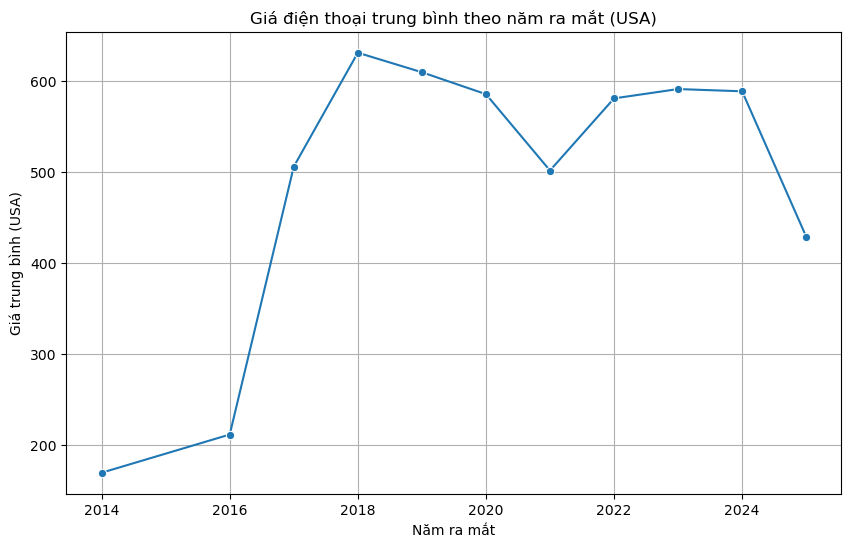

In [199]:
# Loại bỏ giá trị thiếu
df_filtered = data[['Launched Year', 'Launched Price (USA)']].dropna()

# Tính hệ số tương quan Pearson
correlation = df_filtered['Launched Year'].corr(df_filtered['Launched Price (USA)'])
print(f"Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): {correlation:.3f}")

# Tạo bảng trung bình giá theo năm ra mắt
summary = df_filtered.groupby('Launched Year')['Launched Price (USA)'].mean().reset_index()
print(summary)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='Launched Year', y='Launched Price (USA)', marker='o')
plt.title('Giá điện thoại trung bình theo năm ra mắt (USA)')
plt.xlabel('Năm ra mắt')
plt.ylabel('Giá trung bình (USA)')
plt.grid(True)
plt.show()

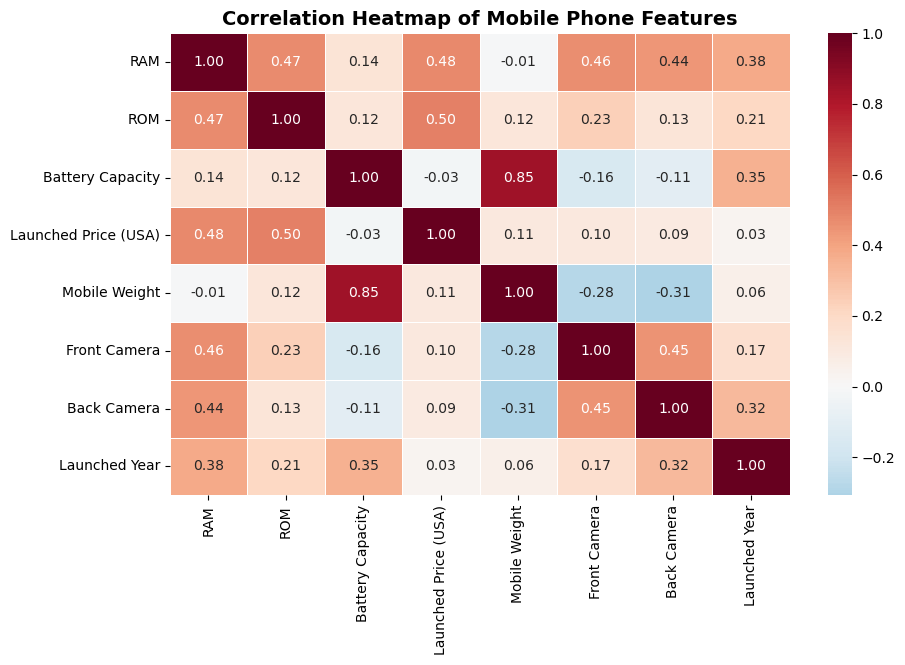

In [200]:
# Select only numerical columns
numeric_data = data[['RAM', 'ROM', 'Battery Capacity', 'Launched Price (USA)', 
                     'Mobile Weight', 'Front Camera', 'Back Camera', 'Launched Year' ]]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Mobile Phone Features", fontsize=14, fontweight="bold")
plt.show()


## Step 5: Train-Test Split

In [201]:
print("Handling missing values...")

for col in ['RAM', 'Front Camera', 'Back Camera'
            , 'Battery Capacity', 'Screen Size']:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        print(f"  {col}: Filled {data[col].isnull().sum()} NaNs with median {median_val:.2f}")

# Remove rows with NaN in target variable
data = data.dropna(subset=['Launched Price (USA)'])

# Remove duplicates
initial_shape = data.shape[0]
data = data.drop_duplicates()
print(f"\n✅ Removed {initial_shape - data.shape[0]} duplicate rows")
print(f"\nFinal shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")

Handling missing values...

✅ Removed 0 duplicate rows

Final shape: (908, 21)
Missing values: 0


In [202]:
# insert data to Mobiles-Dataset-2025-processed.csv
data.to_csv('Mobiles-Dataset-2025-Processed.csv', index=False)

In [203]:
# Drop rows where target variable is NaN
data = data.dropna(subset=['Launched Price (USA)'])

X = data.drop(['Launched Price (USA)', 'Model Name', 'Company Name', 'Processor'], axis=1)
y = data['Launched Price (USA)']
print(X)

     Mobile Weight  RAM  Front Camera  Back Camera  Battery Capacity  \
0            174.0    6          12.0         48.0              3600   
1            174.0    6          12.0         48.0              3600   
2            174.0    6          12.0         48.0              3600   
3            203.0    6          12.0         48.0              4200   
4            203.0    6          12.0         48.0              4200   
..             ...  ...           ...          ...               ...   
924          198.0    6           8.0         50.0              5110   
925          571.0    8           8.0          8.0             10000   
926          571.0    8           8.0          8.0             10000   
927          239.0   12          10.0         50.0              4400   
928          239.0   12          10.0         50.0              4400   

     Screen Size  Launched Year    ROM  Company_Apple  Company_Honor  \
0           6.10           2024  0.125              1          

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
print(X.shape, X_train.shape, X_train.shape)
print(X_train.isnull().sum())

(908, 17) (726, 17) (726, 17)
Mobile Weight       0
RAM                 0
Front Camera        0
Back Camera         0
Battery Capacity    0
Screen Size         0
Launched Year       0
ROM                 0
Company_Apple       0
Company_Honor       0
Company_Oppo        0
Company_Other       0
Company_Samsung     0
Company_Vivo        0
Processor_vec1      0
Processor_vec2      0
Processor_vec3      0
dtype: int64


## Step 7: Standardize Data for KNeighborsRegressor & LR

In [206]:
# Standardized the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [207]:
print(np.isnan(X_train_scaled).sum())
print(np.isnan(X_test_scaled).sum())

0
0


## Step 8: Models Training and Evoluation

In [208]:
models_scaled = {
    "Linear Regression": LinearRegression(),
    "knn_model": KNeighborsRegressor(n_neighbors=5)
}

for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"{name}:")
    print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", round(r2_score(y_test, y_pred) * 100, 2), '%')
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print("=" * 30)


Linear Regression:
RMSE: 249.24822021649126
R2 Score: 62.6 %
MAE:  178.15177469112027
knn_model:
RMSE: 181.56574112280245
R2 Score: 80.16 %
MAE:  119.79176923076922


### ii.  Models That Do NOT Need Scaling:


In [209]:
# Define models with tuned parameters
models_unscaled = {
    "Decision Tree": DecisionTreeRegressor(
        max_depth=20,
        min_samples_split=15,
        min_samples_leaf=8,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
}


# Train & evaluate each model once
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Regression metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2 Score: {r2:.2f} %")
    print("=" * 50)


Decision Tree:
  RMSE: 184.68
  MAE: 126.88
  R2 Score: 79.47 %


Random Forest:
  RMSE: 136.94
  MAE: 93.64
  R2 Score: 88.71 %


## Models Performance 

In [210]:
# Store results in a list
results = []

# Unscaled models
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Scaled models
for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2 Score (%)"])

# Sort by best R² score
results_df = results_df.sort_values(by="R2 Score (%)", ascending=False).reset_index(drop=True)

# Round values for readability
results_df["RMSE"] = results_df["RMSE"].round(2)
results_df["MAE"] = results_df["MAE"].round(2)
results_df["R2 Score (%)"] = results_df["R2 Score (%)"].round(2)

# Print as a clean professional table
print(tabulate(results_df, headers="keys", tablefmt="fancy_grid", showindex=False))


╒═══════════════════╤════════╤════════╤════════════════╕
│ Model             │   RMSE │    MAE │   R2 Score (%) │
╞═══════════════════╪════════╪════════╪════════════════╡
│ Random Forest     │ 136.94 │  93.64 │          88.71 │
├───────────────────┼────────┼────────┼────────────────┤
│ knn_model         │ 181.57 │ 119.79 │          80.16 │
├───────────────────┼────────┼────────┼────────────────┤
│ Decision Tree     │ 184.68 │ 126.88 │          79.47 │
├───────────────────┼────────┼────────┼────────────────┤
│ Linear Regression │ 249.25 │ 178.15 │          62.6  │
╘═══════════════════╧════════╧════════╧════════════════╛



### 📊 Model Performance Comparison

To evaluate different regression algorithms, we trained both **tree-based ensemble models** (Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost) and **scaled models** (Linear Regression, KNN). Performance was compared using **RMSE, MAE, and R² score**.

This combined results table provides a clear benchmark of how each model performs, making it easier to identify the most accurate and reliable model for predicting mobile phone prices.

